In [1]:
import sys

sys.path.append("..")

In [2]:
import open3d as o3d
import numpy as np
import seaborn as sns
import pandas as pd

import re, os
from io import StringIO

import py3Dmol

#from openbabel import pybel

from rdkit import Chem
from rdkit.Chem import AllChem

# Import molgrid after RDkit
# See https://github.com/gnina/libmolgrid/issues/65
import molgrid


from itertools import combinations_with_replacement
from open3d.web_visualizer import draw

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2021-07-01 19:55:43,368 - __init__ - Enabling RDKit 2021.03.3 jupyter extensions


[Open3D INFO] Resetting default logger to print to terminal.


In [3]:
from molgrid_to_pcd import mol_to_grid, grid_to_pcd
from score_pcd import fit_and_score

In [4]:
path = "ligands/BRD4"
files = [os.path.join(path, f) for f in os.listdir(path) if os.path.splitext(f)[-1] == ".sdf"]

# Sort BRD4 ligand files by number
r = re.compile("\d{1,2}")
files.sort(key=lambda f: int(r.search(os.path.basename(f)).group()))

mols = []
for f in files:
    #mol = next(pybel.readfile("sdf", f))
    s = Chem.SDMolSupplier(f)
    mol = next(s)
    mols.append(mol)

print(mols)

[<rdkit.Chem.rdchem.Mol object at 0x7fac3e40e350>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e2b0>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40fc10>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e3a0>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e3f0>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e440>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e490>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e4e0>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e530>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e580>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e5d0>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e620>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e670>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e6c0>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e710>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e760>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e7b0>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e800>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e850>, <rdkit.Chem.rdchem.Mol object at 0x7fac3e40e8a0>]

In [5]:
import ipywidgets as widgets
from ipywidgets import fixed

def update(index=0):
    sio = StringIO()
    with Chem.SDWriter(sio) as w:
        w.write(mols[index])
        
    #view = py3Dmol.view(data=mols[index].write("sdf"), style={'stick':{'colorscheme':'greyCarbon'}})
    view = py3Dmol.view(data=sio.getvalue(), style={'stick':{'colorscheme':'greyCarbon'}})
    view.zoomTo()
    view.show()
    
widgets.interact(update, index=widgets.IntSlider(min=0, max=len(mols)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='index', max=19), Output()), _dom_classes=('widget-intera…

<function __main__.update(index=0)>

In [6]:
# Create conformers for a given molecule
molID = 9
cmol = mols[molID]
cmol = Chem.AddHs(cmol)
cids = AllChem.EmbedMultipleConfs(cmol, numConfs=10)

# https://rdkit.blogspot.com/2016/07/using-ipywidgets-and-py3dmol-to-browse.html

def drawit(m, p, confId=-1):
    mb = Chem.MolToMolBlock(m, confId=confId)
    p.removeAllModels()
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    #p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()

p = py3Dmol.view(width=400,height=400)
widgets.interact(drawit, m=fixed(cmol), p=fixed(p), confId=(0, cmol.GetNumConformers()-1))

interactive(children=(IntSlider(value=0, description='confId', max=9), Output()), _dom_classes=('widget-intera…

<function __main__.drawit(m, p, confId=-1)>

In [7]:
def drawit_nointeractive(m,p ,confId=-1):
        mb = Chem.MolToMolBlock(m,confId=confId)
        p.addModel(mb,'sdf')
        p.setStyle({'stick':{}})
        #p.setBackgroundColor('0xeeeeee')
        p.zoomTo()
    
p = py3Dmol.view(width=400,height=400)
for confId in range(10):
    drawit_nointeractive(cmol, p, confId)
p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [8]:
# Save conformers to separate files
for i in range(cmol.GetNumConformers()):
    with Chem.SDWriter(os.path.join(path, f"conf_{i}.sdf")) as w:
        w.write(cmol, confId=i)
        
n_conf_minus_one = cmol.GetNumConformers() - 1

In [9]:
!ls ligands/BRD4

conf_0.pcd  conf_4.pcd	conf_8.pcd     ligand-2.pcd  ligand-6.pcd
conf_0.sdf  conf_4.sdf	conf_8.sdf     ligand-2.sdf  ligand-6.sdf
conf_1.pcd  conf_5.pcd	conf_9.pcd     ligand-3.pcd  ligand-7.pcd
conf_1.sdf  conf_5.sdf	conf_9.sdf     ligand-3.sdf  ligand-7.sdf
conf_2.pcd  conf_6.pcd	ligand-10.pcd  ligand-4.pcd  ligand-8.pcd
conf_2.sdf  conf_6.sdf	ligand-10.sdf  ligand-4.sdf  ligand-8.sdf
conf_3.pcd  conf_7.pcd	ligand-1.pcd   ligand-5.pcd  ligand-9.pcd
conf_3.sdf  conf_7.sdf	ligand-1.sdf   ligand-5.sdf  ligand-9.sdf


In [10]:
%%bash -s "$path" "$n_conf_minus_one"

# Python variable path passed to bash
# Can be accessed with $1

# Unfortunately molgrid does not work well with pybel
# molgrid_to_pcd needs to run within a Singularity container
# (RDKit and molgrid compiled from source!)
# See https://github.com/gnina/libmolgrid/issues/62

for CONF in $(seq 0 $2)
do
    singularity run --nv --app python ../development/densitymatch.sif \
        ../molgrid_to_pcd.py ${PWD}/${1}/conf_${CONF}.sdf -o ${PWD}/${1}/conf_${CONF}.pcd \
            --ligmap ${PWD}/../files/ligmap
done

In [11]:
!ls ligands/BRD4

conf_0.pcd  conf_4.pcd	conf_8.pcd     ligand-2.pcd  ligand-6.pcd
conf_0.sdf  conf_4.sdf	conf_8.sdf     ligand-2.sdf  ligand-6.sdf
conf_1.pcd  conf_5.pcd	conf_9.pcd     ligand-3.pcd  ligand-7.pcd
conf_1.sdf  conf_5.sdf	conf_9.sdf     ligand-3.sdf  ligand-7.sdf
conf_2.pcd  conf_6.pcd	ligand-10.pcd  ligand-4.pcd  ligand-8.pcd
conf_2.sdf  conf_6.sdf	ligand-10.sdf  ligand-4.sdf  ligand-8.sdf
conf_3.pcd  conf_7.pcd	ligand-1.pcd   ligand-5.pcd  ligand-9.pcd
conf_3.sdf  conf_7.sdf	ligand-1.sdf   ligand-5.sdf  ligand-9.sdf


In [12]:
pcds = []

files = [os.path.join(path, f"conf_{i}.pcd") for i in range(cmol.GetNumConformers())]

print(files)

for f in files:
    pcd = o3d.io.read_point_cloud(f)
    pcds.append(pcd)

print(pcds)

['ligands/BRD4/conf_0.pcd', 'ligands/BRD4/conf_1.pcd', 'ligands/BRD4/conf_2.pcd', 'ligands/BRD4/conf_3.pcd', 'ligands/BRD4/conf_4.pcd', 'ligands/BRD4/conf_5.pcd', 'ligands/BRD4/conf_6.pcd', 'ligands/BRD4/conf_7.pcd', 'ligands/BRD4/conf_8.pcd', 'ligands/BRD4/conf_9.pcd']
[PointCloud with 703 points., PointCloud with 701 points., PointCloud with 714 points., PointCloud with 677 points., PointCloud with 707 points., PointCloud with 663 points., PointCloud with 705 points., PointCloud with 663 points., PointCloud with 690 points., PointCloud with 711 points.]


In [13]:
# Score is not symmetric because RANSAC is currently not deterministic
# See https://github.com/intel-isl/Open3D/issues/1263
# Would the score be symmetric if this was not the case?
n = len(pcds)
Sfitness = np.zeros((n,n))

for i, pcd1 in enumerate(pcds):
    for j, pcd2 in enumerate(pcds):
        gfit, cfit = fit_and_score((pcd1, pcd2), voxel_size=0.5, threshold=0.5)
        Sfitness[i, j] = cfit.fitness

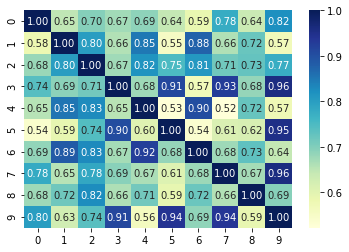

In [19]:
ax = sns.heatmap(Sfitness, cmap="YlGnBu", annot=True, fmt=".2f")

In [21]:
# Compute RMSD